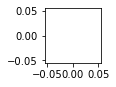

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window

import aggets.ds.moving as moving
import aggets.ds.aggregate3 as aggregate
import aggets.ds.hyper_f_load as hyper_f_load

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot(set_type, model, wg, axs, ylim=None):
    rolling = 300 if set_type == 'train' else 100
    aucs = wg.plot(model=model, model_data_fn=None, last_train=False, lr0=False, lr_t0=True,  # set_type=='train',
                   set_type=set_type, no_lr=False, model_resid=False, rolling=rolling, axs=axs,
                   plot_box_auc=False, lr_tn=10, train=0.5)

    vals = {}
    for key in aucs:
        if '=' in key:
            into = key[key.index('=') - 1:]
        else:
            into = key
        arr = vals.get(into, [])
        arr.append(np.mean(aucs[key].to_numpy()))
        vals[into] = arr
    if ylim is not None:
        plt.ylim(*ylim)
    plt.sca(axs[-1])
    plt.boxplot(list(vals.values()), showfliers=True)
    plt.xticks(range(1, len(vals.keys()) + 1), vals.keys(), rotation=90)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.ylabel('AUC')

In [3]:
data = hyper_f_load.load()

wg = aggregate.WindowGenerator(chunk_size=500, samples=5, sample_frac=0.8, 
                               input_sequence_length=10,
                               df =  data['df'], # full columns information
                               train_df = data['train'],
                               val_df = data['val'],
                               test_df = data['test'],
                               label_columns=['class'],
                               bin_count=1, discretization=20)

wg_tmp = aggregate.WindowGenerator(chunk_size=500, samples=5, sample_frac=0.8, 
                               input_sequence_length=10,
                               df =  data['df'], # full columns information
                               train_df = data['train'],
                               val_df = data['val'],
                               test_df = data['test'],
                               label_columns=['class'],
                               bin_count=1, discretization=20)

In [4]:
wg.init_structures()

In [5]:
import aggets.util as util
util.save(wg, path='window_08.bin') # chunk_size=500, samples=5, sample_frac=0.8, bin_count=1, discretization=20 (lr trains on data without bins), no normalization of aggregates, density included
wg_tmp.load_data(util.load(path='window_08.bin'))

In [7]:
wg_tmp.density = True
wg_tmp.density_encoded = True
wg_tmp.one_row_ts = True

wg_tmp.reverse_train = True
wg_tmp.shuffle_input = False
wg_tmp.shuffle_output = False
wg_tmp.double_target = False
wg_tmp.train_histograms = False

dim_p = wg_tmp.test_agges.shape[-1]
dim_d = wg_tmp.test_agges.shape[-1]
dim_lr = wg_tmp.test_lr.shape[-1]

config in=10, out=5
training model lstm
epoch 0 batch 200 loss=0.0188, MTL=0.0187, MVL=0.0363				
epoch 0 batch 400 loss=0.017, MTL=0.0185, MVL=0.0363				
saving model MTL=0.01845380070664453, MVL=0.01615384076034925
*epoch 1 batch 600 loss=0.0191, MTL=0.0182, MVL=0.0162				
*epoch 1 batch 800 loss=0.0178, MTL=0.0182, MVL=0.0162				
saving model MTL=0.018065224560816485, MVL=0.014873468332359047
*epoch 2 batch 1000 loss=0.0153, MTL=0.0165, MVL=0.0149				
*epoch 2 batch 1200 loss=0.0149, MTL=0.0163, MVL=0.0149				
epoch 3 batch 1400 loss=0.017, MTL=0.016, MVL=0.0155				
epoch 3 batch 1600 loss=0.0149, MTL=0.016, MVL=0.0155				
epoch 4 batch 1800 loss=0.0162, MTL=0.016, MVL=0.0166				
epoch 4 batch 2000 loss=0.0167, MTL=0.0159, MVL=0.0166				


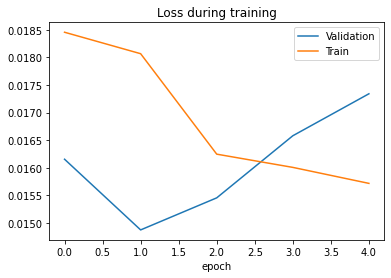

epoch 0 batch 200 loss=0.0142, MTL=0.0163, MVL=0.015				
epoch 0 batch 400 loss=0.0158, MTL=0.0162, MVL=0.015				
epoch 1 batch 600 loss=0.0157, MTL=0.016, MVL=0.0159				
epoch 1 batch 800 loss=0.015, MTL=0.0161, MVL=0.0159				
epoch 2 batch 1000 loss=0.0143, MTL=0.0161, MVL=0.0158				
epoch 2 batch 1200 loss=0.0167, MTL=0.016, MVL=0.0158				
epoch 3 batch 1400 loss=0.0151, MTL=0.0159, MVL=0.0159				
epoch 3 batch 1600 loss=0.0149, MTL=0.0159, MVL=0.0159				
epoch 4 batch 1800 loss=0.0164, MTL=0.0158, MVL=0.0167				
epoch 4 batch 2000 loss=0.0144, MTL=0.0158, MVL=0.0167				


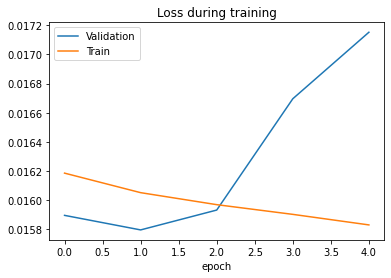

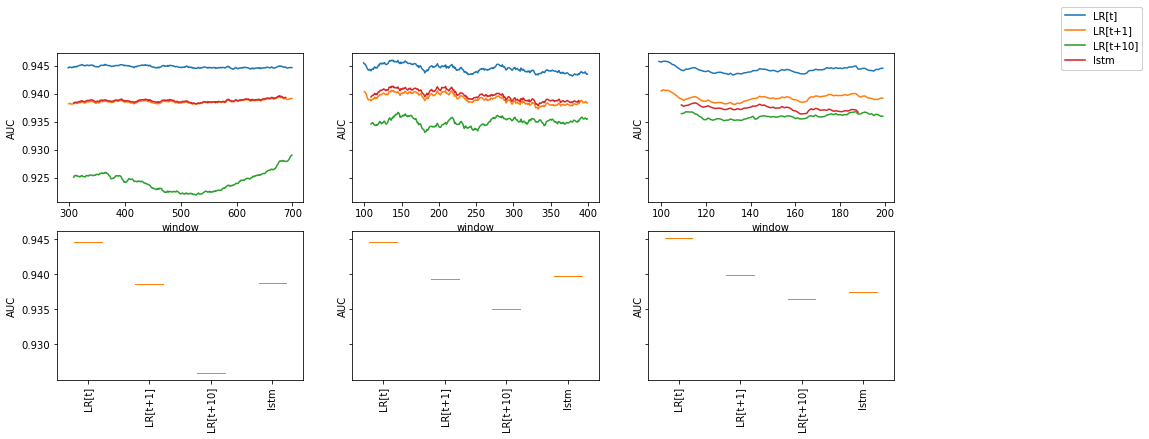

In [11]:
import aggets.model.aggregate as m_agg
import aggets.train as train

wg_tmp.input_sequence_length = 10

model = m_agg.AutoregLstmLr(dim_p + dim_d, dim_lr, num_layers=2, hidden=128,
                            output_sequence_length=5, return_deltas=False)
model.name=f'lstm'
train.train_window_models([model], wg_tmp, patience=5, validate=True, weight_decay=0, max_epochs=5,
                          lrs=[0.001, 0.0001])
model.window_config.output_sequence_length = 1
model.return_deltas = False

def plot_only(models, wg, ylim=None):
    _, axs = plt.subplots(ncols=3, nrows=2, sharey='row', figsize=(15,6))
    plot('train', models, wg, axs=[axs[0][0], axs[1][0]], ylim=ylim)
    plot('val',   models, wg, axs=[axs[0][1], axs[1][1]], ylim=ylim)
    plot('test',  models, wg, axs=[axs[0][2], axs[1][2]], ylim=ylim)
plot_only([model], wg_tmp)